In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import dill
import numpy as np
import os
import matplotlib.pyplot as plt
# import matplotlib.transforms
import math
import pandas as pd
# import random
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy.optimize import minimize
from scipy.stats import norm
# import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS

os.chdir('D:\Documents\MGT 6090\Assignment 10')

In [ ]:
# import saved dataframes
funda = pd.read_pickle('funda.pkl')
ann_ret = pd.read_pickle('ann_ret.pkl')
sigma_e = pd.read_pickle('sigma_e.pkl')
E = pd.read_pickle('E.pkl')
rf = pd.read_pickle('rf.pkl')


In [ ]:
# import and format funda data
funda = pd.read_csv("funda.csv", usecols=['DATADATE', 'CUSIP', 'DLC', 'DLTT', 'INDFMT', 'DATAFMT', 'POPSRC', 'FIC', 'CONSOL'], 
                      parse_dates=['DATADATE'], 
                      dtype={'CUSIP': pd.StringDtype(), 'DLC': float, 'DLTT': float, 'INDFMT': pd.StringDtype(), 
                            'DATAFMT': pd.StringDtype(), 'POPSRC': pd.StringDtype(), 'FIC': pd.StringDtype(), 'CONSOL': pd.StringDtype()})

# filter to desired values
funda = funda.loc[(funda['INDFMT'] == 'INDL') & 
                 (funda['DATAFMT'] == 'STD') & 
                 (funda['POPSRC'] == 'D') & 
                 (funda['FIC'] == 'USA') & 
                 (funda['CONSOL'] == 'C')]

# generate lagged year column and filter to desired years
funda['YEAR'] = funda['DATADATE'].dt.year + 1
funda = funda.loc[(funda['YEAR'] >= 1970) & (funda['YEAR'] <= 2020)]

# calculate face value of debt
funda['DLC'] = funda['DLC'] * 1000000
funda['DLTT'] = funda['DLTT'] * 1000000
funda['F'] = funda['DLC'] + 0.5 * funda['DLTT']

# get rid of unneeded columns and null rows
funda.drop(['DATADATE', 'INDFMT', 'DATAFMT', 'POPSRC', 'FIC', 'CONSOL', 'DLC', 'DLTT'], axis=1, inplace=True)
funda = funda.loc[(np.isnan(funda['F']) == False) & 
                 (pd.isnull(funda['CUSIP']) == False) & 
                 (pd.isnull(funda['YEAR']) == False)]

# update CUSIP
funda['CUSIP'] = funda['CUSIP'].str[0:6]

# funda.to_pickle('funda.pkl')

In [ ]:
# import and format daily crsp data
crsp = pd.read_csv("crsp_dsf_full_DD.csv", usecols=['date', 'CUSIP', 'PRC', 'SHROUT', 'RET'], 
                      parse_dates=['date'], 
                      dtype={'CUSIP': pd.StringDtype(), 'PRC': float, 'SHROUT': float, 'RET': pd.StringDtype()})

# get numeric returns
crsp = crsp[pd.to_numeric(crsp['RET'], errors='coerce').notnull()]
crsp['RET'] = pd.to_numeric(crsp['RET'])

# generate lagged year column and filter to desired years
crsp['YEAR'] = crsp['date'].dt.year + 1
crsp = crsp.loc[(crsp['YEAR'] >= 1970) & (crsp['YEAR'] <= 2021)]

# adjust CUSIP to match compustat data
crsp['CUSIP'] = crsp['CUSIP'].str[0:6]

# get rid of null/na values
crsp = crsp.loc[(np.isnan(crsp['RET']) == False) & 
                 (np.isnan(crsp['PRC']) == False) & 
                 (np.isnan(crsp['SHROUT']) == False)]


# calculate daily market cap
crsp['E'] = crsp['PRC'].abs() * crsp['SHROUT'] * 1000

# calculate annual compounded return
ann_ret = crsp.groupby(by=['CUSIP', 'YEAR']).apply(lambda x: np.exp(np.sum(np.log(1+x['RET'])))).reset_index()
ann_ret.rename(columns={0:'RET'}, inplace=True)

# calculate volatility of equity
sigma_e = (crsp.groupby(by=['CUSIP', 'YEAR'])[['RET']].std() * np.sqrt(250)).reset_index()
sigma_e.rename(columns={'RET':'sigma_e'}, inplace=True)
# get rid of NaN sigma_e values
sigma_e = sigma_e.loc[np.isnan(sigma_e['sigma_e']) == False]

# calculate current market cap
E = crsp.groupby(by = ['CUSIP', 'YEAR'])['E'].first().reset_index()
# don't want to lag current market cap
E['YEAR'] = E['YEAR'] - 1

E.head(n=10)

# crsp.to_pickle('crsp.pkl')
# ann_ret.to_pickle('ann_ret.pkl')
# sigma_e.to_pickle('sigma_e.pkl')
# E.to_pickle('E.pkl')

In [ ]:
dailyfed = pd.read_csv("DAILYFED.csv", usecols=['DATE', 'DTB3'], parse_dates=['DATE'], dtype={'DTB3': pd.StringDtype()})
dailyfed = dailyfed[pd.to_numeric(dailyfed['DTB3'], errors='coerce').notnull()]
dailyfed['DTB3'] = pd.to_numeric(dailyfed['DTB3'])
dailyfed.rename(columns={'DATE': 'date'}, inplace=True)
dailyfed['YEAR'] = dailyfed['date'].dt.year
dailyfed['rf'] = np.log(1 + dailyfed['DTB3']/100) 
rf = dailyfed.groupby(by=['YEAR'])['rf'].first().reset_index()

# dailyfed.to_pickle('dailyfed.pkl')
# rf.to_pickle('rf.pkl')

In [ ]:
# join dataframes
kmv_base = (funda.merge(ann_ret, how='inner', on=['CUSIP', 'YEAR'])
    .merge(sigma_e, how='inner', on=['CUSIP', 'YEAR'])
    .merge(E, how='inner', on=['CUSIP', 'YEAR'])
    .merge(rf, how='left', on=['YEAR']))

# kmv_base.to_pickle('kmv_base.pkl')


In [39]:
# get kmv base
kmv1 = pd.read_pickle('kmv_base.pkl')
T = 1

# calculate naive kmv
kmv1['naive_sigma_v1'] = kmv1['E'] / (kmv1['E'] + kmv1['F']) * kmv1['sigma_e'] + \
    kmv1['F'] / (kmv1['E'] + kmv1['F']) * (0.05 + 0.25 * kmv1['sigma_e'])
kmv1['naive_sigma_v2'] = kmv1['E'] / (kmv1['E'] + kmv1['F']) * kmv1['sigma_e'] + \
    kmv1['F'] / (kmv1['E'] + kmv1['F']) * (0.05 + 0.5 * kmv1['sigma_e'])
kmv1['naive_sigma_v3'] = kmv1['E'] / (kmv1['E'] + kmv1['F']) * kmv1['sigma_e'] + \
    kmv1['F'] / (kmv1['E'] + kmv1['F']) * (0.25 * kmv1['sigma_e'])

kmv1['dd_naive1'] = (np.log((kmv1['E'] + kmv1['F']) / kmv1['F']) + (kmv1['RET'] - 1 - np.power(kmv1['naive_sigma_v1'], 2) / 2) * T) / \
    (kmv1['naive_sigma_v1'] * np.sqrt(T))
kmv1['dd_naive2'] = (np.log((kmv1['E'] + kmv1['F']) / kmv1['F']) + (kmv1['RET'] - 1 - np.power(kmv1['naive_sigma_v2'], 2) / 2) * T) / \
    (kmv1['naive_sigma_v2'] * np.sqrt(T))
kmv1['dd_naive3'] = (np.log((kmv1['E'] + kmv1['F']) / kmv1['F']) + (kmv1['RET'] - 1 - np.power(kmv1['naive_sigma_v3'], 2) / 2) * T) / \
    (kmv1['naive_sigma_v3'] * np.sqrt(T))
                
kmv1.drop(['naive_sigma_v1', 'naive_sigma_v2', 'naive_sigma_v3'], axis=1, inplace=True)

kmv1['pd_naive1'] = norm.cdf(-1 * kmv1['dd_naive1'])
kmv1['pd_naive2'] = norm.cdf(-1 * kmv1['dd_naive2'])
kmv1['pd_naive3'] = norm.cdf(-1 * kmv1['dd_naive3'])

# kmv1.to_pickle('kmv1.pkl')

In [ ]:
# get kmv base
kmv2 = pd.read_pickle('kmv_base.pkl')
T = 1

# calculate black scholes kmv
# sol[0] is firm value
# sol[1] is asset volatility
def black_scholes_kmv(x, E, sigma_e, F, r, T):
    # get values as floats
    E, sigma_e, F, r, T = float(E), float(sigma_e), float(F), float(r), float(T)
    # get intermediate values
    d1 = (np.log(x[0] / F) + T * (r + (x[1]**2) / 2)) / (x[1] * np.sqrt(T))
    d2 = d1 - x[1] * np.sqrt(T)
    # set black scholes and ito's lemma equations equal to zero
    eq1 = x[0] * norm.cdf(d1) - np.exp(-r * T) * F * norm.cdf(d2) - E
    eq2 = x[0] / E * norm.cdf(d1) * x[1] - sigma_e
#     return(eq1**2 + eq2**2)
    return [eq1, eq2]

def get_black_scholes_kmv(E, sigma_e, F, r, T):
    # get optimized solutions
    sols = fsolve(black_scholes_kmv, [E + F, 0.01], args=(E, sigma_e, F, r, T), full_output=True)
    # if no solution was found, return nan values
    if sols[2] != 1:
        return np.nan, np.nan
    # else return optimized values
    return sols[0][0], sols[0][1]
#     return sols[0], sols[1]
    
    
kmv2['V_bs'], kmv2['sigma_v_bs'] = zip(*kmv2.apply(lambda x: get_black_scholes_kmv(x['E'], x['sigma_e'], x['F'], x['rf'], T), axis=1))
# get rid of solutions that didn't converge
kmv2 = kmv2.loc[(np.isnan(kmv2['V_bs']) == False) & (np.isnan(kmv2['sigma_v_bs']) == False)]
kmv2 = kmv2.loc[kmv2['sigma_v_bs'] >= 0]
kmv2['dd_bs'] = ((np.log(kmv2['V_bs'] / kmv2['F']) + T * (kmv2['RET'] - 1 - np.power(kmv2['sigma_v_bs'], 2) / 2)) / (kmv2['sigma_v_bs'] * np.sqrt(T)))
kmv2['pd_bs'] = norm.cdf(-1 * kmv2['dd_bs'])

# kmv2.to_pickle('kmv2.pkl')

In [ ]:
# join daily rf data to crsp data
dailyfed = pd.read_pickle('dailyfed.pkl')
crsp = pd.read_pickle('crsp.pkl')
crsp_rf = crsp.merge(dailyfed.loc[:, ['date', 'rf']], how='left', on=['date'])
crsp_rf = crsp_rf.loc[crsp_rf['rf'].notna()]

# get kmv base
kmv3 = pd.read_pickle('kmv_base.pkl')
# filter to 1990-2020
kmv3 = kmv3.loc[(kmv3['YEAR'] >= 1990) & (kmv3['YEAR'] <= 2020)]
# sample 1000 firms
gtID_seed = 902953178
np.random.seed(gtID_seed)
iter_firms = np.random.choice(kmv3.loc[kmv3['YEAR'] == 1990]['CUSIP'].unique(), size=1000)
# get selected firm years
kmv3 = kmv3[kmv3['CUSIP'].isin(iter_firms)]

# kmv3.to_pickle('kmv3_base.pkl')

# filter crsp_rf to the years and firms as well
crsp_rf = crsp_rf.loc[(crsp_rf['YEAR'] >= 1990) & (crsp_rf['YEAR'] <= 2020)]
crsp_rf = crsp_rf[crsp_rf['CUSIP'].isin(iter_firms)]
crsp_rf.drop(['PRC', 'RET', 'SHROUT'], axis=1, inplace=True)

# crsp_rf.to_pickle('crsp_rf.pkl')


In [ ]:
kmv3 = pd.read_pickle('kmv3_base.pkl')
crsp_rf = pd.read_pickle('crsp_rf.pkl')
T = 1

# calculate firm value given sigma_v
def bs_firm_val(x, E, sigma_v, F, r, T):
    # get values as floats
    E, sigma_v, F, r, T = float(E), float(sigma_v), float(F), float(r), float(T)
    # get intermediate values
    d1 = (np.log(x[0] / F) + T * (r + (sigma_v**2) / 2)) / (sigma_v * np.sqrt(T))
    d2 = d1 - sigma_v * np.sqrt(T)
    # set black scholes equation equal to zero
    eq1 = x[0] * norm.cdf(d1) - np.exp(-r * T) * F * norm.cdf(d2) - E
    return eq1

# calculate and parse black scholes firm value
def get_bs_firm_val(E, sigma_v, F, r, T):
    # get value of V with sigma_v 
    sol = fsolve(bs_firm_val, [E + F], args=(E, sigma_v, F, r, T), full_output=True)
    # if no solution was found, return nan value
    if sol[2] != 1:
        return np.nan
    # else return solved value
    return sol[0][0]    

firm_yr_count = 0
# iteratively calculate firm-year V and sigma_v
def get_kmv_iter(crsp, cusip, year, E, r, F, sigma_e, T):
    # get relevant firm year data from crsp
    firm_yr = crsp.loc[(crsp['CUSIP'] == cusip) & (crsp['YEAR'] == year)]
    # use sigma_e as initial guess
    sigma_v_old = sigma_e
    sigma_v_new = sigma_e
    iters = 0
    sigma_diff = 1
    # repeat process using new guess for sigma_v until convergence or we reach 20 iterations
    while sigma_diff > 10**-5:
        # if we reach 20 iterations without convergence, return nan
        if iters >= 20:
            return np.nan
        # otherwise repeat steps to get updates for sigma_v
        sigma_v_old = sigma_v_new
        firm_yr['V'] = firm_yr.apply(lambda x: get_bs_firm_val(x['E'], sigma_v_old, F, x['rf'], T), axis=1)
        # if all NA go to next
        if firm_yr['V'].isna().all():
            return np.nan
        # get rid of possible NaN values
        firm_yr = firm_yr.loc[np.isnan(firm_yr['V']) == False]
        # create column of lagged values
        firm_yr['V_lag'] = firm_yr['V'].shift(1)
        # calculate firm value returns and get annualized standard deviation for new sigma_v estimate
        sigma_v_new = (firm_yr['V'] / firm_yr['V_lag']).std() * np.sqrt(250)
        sigma_diff = abs(sigma_v_old - sigma_v_new)
        iters = iters + 1
    # just to help with program progress
    global firm_yr_count
    firm_yr_count = firm_yr_count + 1
    if firm_yr_count % 10 == 0:
        print(firm_yr_count)
    # return final sigma_v value
    return sigma_v_new

# calculate V and sigma_v for all firm years
kmv3['sigma_v_iter'] = kmv3.apply(lambda x: get_kmv_iter(crsp_rf, x['CUSIP'], x['YEAR'], x['E'], x['rf'], x['F'], x['sigma_e'], T), axis=1)
kmv3['V_iter'] = kmv3.apply(lambda x: get_bs_firm_val(x['E'], x['sigma_v_iter'], x['F'], x['rf'], T), axis=1)

# calculate DD and PD
kmv3['dd_iter'] = ((np.log(kmv3['V_iter'] / kmv3['F']) + T * (kmv3['RET'] - 1 - np.power(kmv3['sigma_v_iter'], 2) / 2)) / (kmv3['sigma_v_iter'] * np.sqrt(T)))
kmv3['pd_iter'] = norm.cdf(-1 * kmv3['dd_iter'])

# kmv3.to_pickle('kmv3.pkl')


In [3]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

stat_fns = ['count', 'mean', 'std', 'min', q25, 'median', q75, 'max']
plot_fns = ['mean', q25, 'median', q75]


In [4]:
# calculate descriptive stats for methods
kmv1 = pd.read_pickle('kmv1.pkl')
# filter out bad values
kmv1 = kmv1.loc[(np.isfinite(kmv1['dd_naive1'])) & 
                (np.isfinite(kmv1['dd_naive2'])) & 
                (np.isfinite(kmv1['dd_naive3']))]
kmv1.to_pickle('kmv1.pkl')

kmv1_agg_dd = kmv1.agg({'dd_naive1': stat_fns,
                        'dd_naive2': stat_fns,
                        'dd_naive3': stat_fns})
kmv1_agg_pd = kmv1.agg({'pd_naive1': stat_fns,
                        'pd_naive2': stat_fns,
                        'pd_naive3': stat_fns})

kmv1_agg_dd.to_pickle('kmv1_agg_dd.pkl')
kmv1_agg_pd.to_pickle('kmv1_agg_pd.pkl')


kmv2 = pd.read_pickle('kmv2.pkl')
# filter out bad values
kmv2 = kmv2.loc[(np.isfinite(kmv2['dd_bs']))]
kmv2 = kmv2.loc[kmv2['sigma_e'] != 0.0]
kmv2 = kmv2.loc[kmv2['sigma_v_bs'] != 0.01]
kmv2.to_pickle('kmv2.pkl')

kmv2_agg = kmv2.agg({'dd_bs': stat_fns,
                     'pd_bs': stat_fns})

kmv2_agg.to_pickle('kmv2_agg.pkl')

kmv3 = pd.read_pickle('kmv3.pkl')
# filter out bad values
kmv3 = kmv3.loc[(np.isfinite(kmv3['dd_iter']))]
kmv3 = kmv3.loc[kmv3['sigma_e'] != 0.0]
kmv3.to_pickle('kmv3.pkl')

kmv3_agg = kmv3.agg({'dd_iter': stat_fns,
                     'pd_iter': stat_fns})

kmv3_agg.to_pickle('kmv3_agg.pkl')


In [5]:
# Method 1 DD and PD Descriptive Stats

kmv1_agg_dd = pd.read_pickle('kmv1_agg_dd.pkl')
kmv1_agg_pd = pd.read_pickle('kmv1_agg_pd.pkl')
kmv1_agg_dd
kmv1_agg_pd

,dd_naive1,dd_naive2,dd_naive3
count,192031.000000,192031.000000,192031.000000
mean,5.869934,5.604568,6.127418
std,5.866646,5.804907,9.115865
min,-9.010434,-9.125004,-9.009234
q25,2.248173,1.970016,2.391616
median,4.851107,4.510630,5.116926
q75,8.181489,7.848818,8.545329
max,782.608265,781.009107,2985.099231


,pd_naive1,pd_naive2,pd_naive3
count,1.920310e+05,1.920310e+05,1.920310e+05
mean,7.849295e-02,8.623026e-02,7.615972e-02
std,2.008657e-01,2.032773e-01,2.014200e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
q25,1.401788e-16,2.099884e-15,6.408546e-18
median,6.138719e-07,3.231771e-06,1.552781e-07
q75,1.228259e-02,2.441826e-02,8.387197e-03
max,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
# Method 2 DD and PD Descriptive Stats

kmv2_agg = pd.read_pickle('kmv2_agg.pkl')
kmv2_agg

,dd_bs,pd_bs
count,180245.000000,1.802450e+05
mean,6.982726,5.441718e-02
std,32.199882,1.835348e-01
min,-3043.085480,0.000000e+00
q25,3.154158,4.249452e-21
median,5.879465,2.057979e-09
q75,9.353257,8.048101e-04
max,9097.011641,1.000000e+00


In [7]:
# Generate yearly values to plot
kmv1 = pd.read_pickle('kmv1.pkl')

kmv1_years = kmv1.groupby(by=['YEAR']).agg({'dd_naive1': plot_fns,
                                            'dd_naive2': plot_fns,
                                            'dd_naive3': plot_fns,
                                            'pd_naive1': plot_fns,
                                            'pd_naive2': plot_fns,
                                            'pd_naive3': plot_fns})

kmv2 = pd.read_pickle('kmv2.pkl')

kmv2_years = kmv2.groupby(by=['YEAR']).agg({'dd_bs': plot_fns, 'pd_bs': plot_fns})

kmv3 = pd.read_pickle('kmv3.pkl')

kmv3_years = kmv3.groupby(by=['YEAR']).agg({'dd_iter': plot_fns, 'pd_iter': plot_fns})

plot_vals_12 = kmv1_years.merge(kmv2_years, how='inner', on=['YEAR'])
plot_vals_123 = plot_vals_12.merge(kmv3_years, how='inner', on=['YEAR'])

plot_vals_12.reset_index(inplace=True)
plot_vals_12['date'] = pd.to_datetime(plot_vals_12['YEAR'].astype(str) + '-01-01', format='%Y-%m-%d')

plot_vals_123.reset_index(inplace=True)
plot_vals_123['date'] = pd.to_datetime(plot_vals_123['YEAR'].astype(str) + '-01-01', format='%Y-%m-%d')

plot_vals_12.to_pickle('plot_vals_12.pkl')
plot_vals_123.to_pickle('plot_vals_123.pkl')


In [8]:
# calculate correlation matrix
corr_12_dd = (kmv1.loc[:, ['CUSIP', 'YEAR', 'dd_naive1', 'dd_naive2', 'dd_naive3']].merge(
    kmv2.loc[:, ['CUSIP', 'YEAR', 'dd_bs']], how='inner', on=['CUSIP', 'YEAR'])
    .loc[:, ['dd_naive1', 'dd_naive2', 'dd_naive3', 'dd_bs']]).corr()

corr_12_dd.to_pickle('corr_12_dd.pkl')

corr_12_pd = (kmv1.loc[:, ['CUSIP', 'YEAR', 'pd_naive1', 'pd_naive2', 'pd_naive3']].merge(
    kmv2.loc[:, ['CUSIP', 'YEAR', 'pd_bs']], how='inner', on=['CUSIP', 'YEAR'])
    .loc[:, ['pd_naive1', 'pd_naive2', 'pd_naive3', 'pd_bs']]).corr()

corr_12_pd.to_pickle('corr_12_pd.pkl')

corr_123_dd = (kmv1.loc[:, ['CUSIP', 'YEAR', 'dd_naive1', 'dd_naive2', 'dd_naive3']]
               .merge(kmv2.loc[:, ['CUSIP', 'YEAR', 'dd_bs']], how='inner', on=['CUSIP', 'YEAR'])
               .merge(kmv3.loc[:, ['CUSIP', 'YEAR', 'dd_iter']], how='inner', on=['CUSIP', 'YEAR'])
               .loc[:, ['dd_naive1', 'dd_naive2', 'dd_naive3', 'dd_bs', 'dd_iter']]).corr()

corr_123_pd = (kmv1.loc[:, ['CUSIP', 'YEAR', 'pd_naive1', 'pd_naive2', 'pd_naive3']]
               .merge(kmv2.loc[:, ['CUSIP', 'YEAR', 'pd_bs']], how='inner', on=['CUSIP', 'YEAR'])
               .merge(kmv3.loc[:, ['CUSIP', 'YEAR', 'pd_iter']], how='inner', on=['CUSIP', 'YEAR'])
               .loc[:, ['pd_naive1', 'pd_naive2', 'pd_naive3', 'pd_bs', 'pd_iter']]).corr()

corr_123_dd.to_pickle('corr_123_dd.pkl')
corr_123_pd.to_pickle('corr_123_pd.pkl')


In [9]:
# Method 1 and 2 DD Correlations

corr_12_dd = pd.read_pickle('corr_12_dd.pkl')
corr_12_dd

,dd_naive1,dd_naive2,dd_naive3,dd_bs
dd_naive1,1.000000,0.998194,0.648218,0.194526
dd_naive2,0.998194,1.000000,0.644652,0.187849
dd_naive3,0.648218,0.644652,1.000000,0.272064
dd_bs,0.194526,0.187849,0.272064,1.000000


In [10]:
# Method 1 and 2 PD Correlations

corr_12_pd = pd.read_pickle('corr_12_pd.pkl')
corr_12_pd

,pd_naive1,pd_naive2,pd_naive3,pd_bs
pd_naive1,1.000000,0.992904,0.998445,0.980827
pd_naive2,0.992904,1.000000,0.985702,0.961190
pd_naive3,0.998445,0.985702,1.000000,0.985183
pd_bs,0.980827,0.961190,0.985183,1.000000


The first and second naive distance to default calculations are highly correlated. The third naive distance to default calculation is very weakly correlated with the black scholes direct solving method. For the probability to default, all the method values are highly correlated. The black scholes direct solver is most closely correlated to the third naive method.

In [11]:
# import recession data
usrec = pd.read_csv("USREC.csv", usecols=['DATE', 'USREC'],
                    parse_dates=['DATE'], dtype={'USREC': float})
usrec_1970 = usrec.loc[usrec['DATE'] >= '1970-01-01']
usrec_1990 = usrec.loc[usrec['DATE'] >= '1990-01-01']

# import BAAFFM data
baaffm = pd.read_csv("BAAFFM.csv", usecols=['DATE', 'BAAFFM'], 
                      parse_dates=['DATE'], dtype={'BAAFFM': float})
baaffm_1970 = baaffm.loc[baaffm['DATE'] >= '1970-01-01']
baaffm_1990 = baaffm.loc[baaffm['DATE'] >= '1990-01-01']

# import CFSI data
cfsi = pd.read_csv("CFSI.csv", usecols=['DATE', 'CFSI'],
                   parse_dates=['DATE'], dtype={'CFSI': float})

In [12]:
# plot dataframe with multiple lines
def plot_df(df, legend_on, plot1_num_lines, y_name, usrec_df, baaffm_df, cfsi_df, sub_plot=False,
            fig_size=(5,5), legend_loc=None, legend_bbox=None, legend_ncol=1):
    plt.figure()
    df_cols = df.columns.tolist()

    # initialize plot and axis
    # determine whether or not to plot other df values in sub plot
    if not sub_plot:
        fig, ax1 = plt.subplots(figsize=fig_size)
        # plot usrec values
        if usrec_df is not None:
            ax1.plot('DATE', 'USREC', data=usrec_df)
        # plot baaffm values
        if baaffm_df is not None:
            ax1.plot('DATE', 'BAAFFM', data=baaffm_df)
        # plot cfsi values
        if cfsi_df is not None:
            ax1.plot('DATE', 'CFSI', data=cfsi_df)        
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size)
        ax2.set_xlabel('Year')
        # plot usrec values
        if usrec_df is not None:
            ax2.plot('DATE', 'USREC', data=usrec_df)
            ax2.set_ylabel('USREC')
        # plot baaffm values
        if baaffm_df is not None:
            ax2.plot('DATE', 'BAAFFM', data=baaffm_df)
            ax2.set_ylabel('BAAFFM')
        # plot cfsi values
        if cfsi_df is not None:
            ax2.plot('DATE', 'CFSI', data=cfsi_df)
            ax2.set_ylabel('CFSI')
    
    # plot all other vals, increment df_cols by one because of years column
    for i in range(plot1_num_lines):
        ax1.plot('date', df_cols[i+1], data=df)
    # set ax1 values
    ax1.set_xlabel('Year')
    ax1.set_ylabel(y_name)
    if legend_on:
        if legend_loc is None and legend_bbox is None:
            ax1.legend()
        else:
            ax1.legend(bbox_to_anchor=legend_bbox, loc = legend_loc, ncol=legend_ncol)
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()
#     plt.close()
    return

In [13]:
# generate dataframes for mean, q25, median, q75 stats
plot_fn_names = ['mean', 'q25', 'median', 'q75']
df_12_list = [plot_vals_12.loc[:, [('date', ''), ('dd_naive1', val), ('dd_naive2', val), 
                                   ('dd_naive3', val), ('dd_bs', val)]] for val in plot_fn_names]

for df in df_12_list:
    df.columns = ['date', 'dd_naive1', 'dd_naive2', 'dd_naive3', 'dd_direct']


<Figure size 432x288 with 0 Axes>

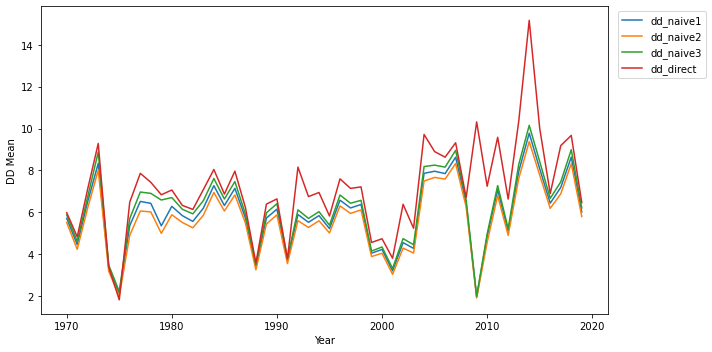

In [14]:
# DD Mean for each Year for Method 1 and Method 2

plot_df(df_12_list[0], True, 4, 'DD Mean', None, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

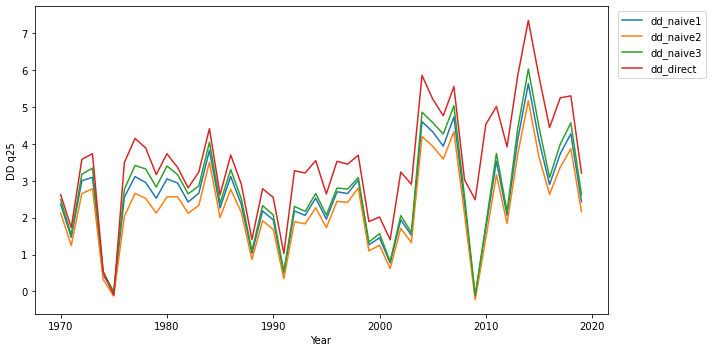

In [15]:
# DD q25 for each Year for Method 1 and Method 2

plot_df(df_12_list[1], True, 4, 'DD q25', None, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

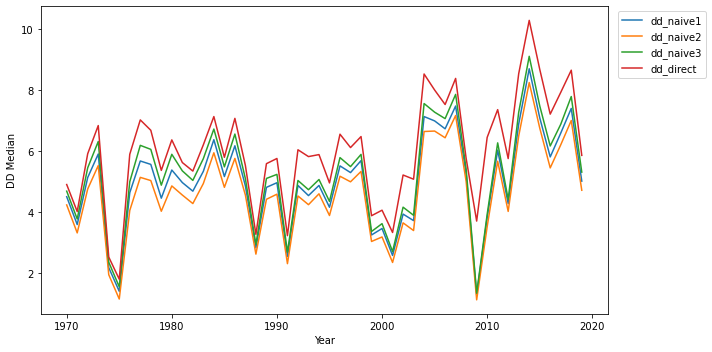

In [16]:
# DD Median for each Year for Method 1 and Method 2

plot_df(df_12_list[2], True, 4, 'DD Median', None, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

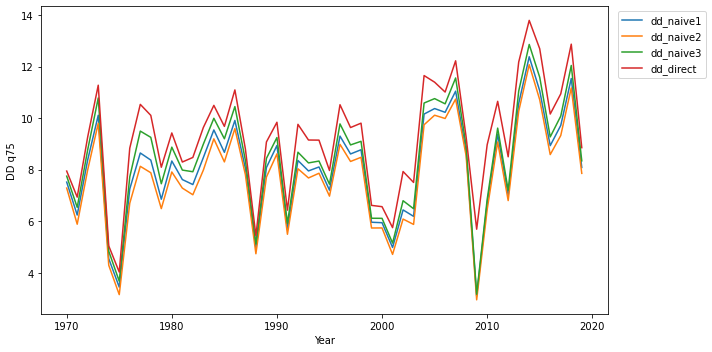

In [17]:
# DD q75 for each Year for Method 1 and Method 2

plot_df(df_12_list[3], True, 4, 'DD q75', None, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

The direct solving method distance to default values are almost always higher than the naive methods. Out of the naive methods, naive method 3 is usually the largest distance to default, naive method 1 is in the middle, and naive method 2 is the smallest distance to default. When it comes to the mean values, around year 2007 or 2008, there is a large spike in the mean for the direct solving method, while the naive values all show a dip in the mean. This dip in the mean in 2007 or 2008 also occurs in the q25, median, and q75 graphs. It looks like there are some outlier distance to default values in the direct solving method influencing the mean heavily.

## Plots and Tables with NBER Recession/BAAFFM/CFSI data are at the end

In [18]:
# Computing yearly NBER data
# if at least half the months had recession indidcators then we label it a recession year
def is_rec_year(count):
    if count >= 6:
        return 1
    return 0
usrec['YEAR'] = usrec['DATE'].dt.year
usrec_year = usrec.groupby(by=['YEAR']).sum().reset_index()
usrec_year['USREC'] = usrec_year.apply(lambda x: is_rec_year(x['USREC']), axis=1)

# join to firm year data
kmv1_rec = kmv1.merge(usrec_year, how='inner', on=['YEAR'])
kmv2_rec = kmv2.merge(usrec_year, how='inner', on=['YEAR'])
kmv3_rec = kmv3.merge(usrec_year, how='inner', on=['YEAR'])

# calculate descriptive stats
kmv1_rec1_dd = kmv1_rec.loc[kmv1_rec['USREC'] == 1].agg({'dd_naive1': stat_fns,
                                                         'dd_naive2': stat_fns,
                                                         'dd_naive3': stat_fns})
kmv1_rec1_pd = kmv1_rec.loc[kmv1_rec['USREC'] == 1].agg({'pd_naive1': stat_fns,
                                                         'pd_naive2': stat_fns,
                                                         'pd_naive3': stat_fns})

kmv1_rec0_dd = kmv1_rec.loc[kmv1_rec['USREC'] == 0].agg({'dd_naive1': stat_fns,
                                                         'dd_naive2': stat_fns,
                                                         'dd_naive3': stat_fns})
kmv1_rec0_pd = kmv1_rec.loc[kmv1_rec['USREC'] == 0].agg({'pd_naive1': stat_fns,
                                                         'pd_naive2': stat_fns,
                                                         'pd_naive3': stat_fns})

kmv2_rec1 = kmv2_rec.loc[kmv2_rec['USREC'] == 1].agg({'dd_bs': stat_fns, 'pd_bs': stat_fns})
kmv2_rec0 = kmv2_rec.loc[kmv2_rec['USREC'] == 0].agg({'dd_bs': stat_fns, 'pd_bs': stat_fns})

kmv3_rec1 = kmv3_rec.loc[kmv3_rec['USREC'] == 1].agg({'dd_iter': stat_fns, 'pd_iter': stat_fns})
kmv3_rec0 = kmv3_rec.loc[kmv3_rec['USREC'] == 0].agg({'dd_iter': stat_fns, 'pd_iter': stat_fns})

In [19]:
# Method 3 DD and PD Descriptive Stats

kmv3_agg = pd.read_pickle('kmv3_agg.pkl')
kmv3_agg

,dd_iter,pd_iter
count,9855.000000,9.855000e+03
mean,6.751938,8.213964e-02
std,6.274880,2.222606e-01
min,-143.307661,0.000000e+00
q25,2.637360,9.267429e-23
median,5.821136,2.922442e-09
q75,9.749519,4.177707e-03
max,59.382654,1.000000e+00


In [20]:
# Method 1, 2, and 3 DD Correlations

corr_123_dd = pd.read_pickle('corr_123_dd.pkl')
corr_123_dd

,dd_naive1,dd_naive2,dd_naive3,dd_bs,dd_iter
dd_naive1,1.000000,0.998705,0.997493,0.180156,0.903756
dd_naive2,0.998705,1.000000,0.993067,0.177675,0.892648
dd_naive3,0.997493,0.993067,1.000000,0.182637,0.914417
dd_bs,0.180156,0.177675,0.182637,1.000000,0.192715
dd_iter,0.903756,0.892648,0.914417,0.192715,1.000000


In [21]:
# Method 1, 2, and 3 PD Correlations

corr_123_pd = pd.read_pickle('corr_123_pd.pkl')
corr_123_pd

,pd_naive1,pd_naive2,pd_naive3,pd_bs,pd_iter
pd_naive1,1.000000,0.993532,0.998726,0.982514,0.957052
pd_naive2,0.993532,1.000000,0.987355,0.964107,0.943974
pd_naive3,0.998726,0.987355,1.000000,0.986809,0.959277
pd_bs,0.982514,0.964107,0.986809,1.000000,0.957148
pd_iter,0.957052,0.943974,0.959277,0.957148,1.000000


For the firm-years in 1990-2020 and the random sampled 1000 firms, there are some differing trends than the earlier correlations. There already weak correlation between the black scholes direct solving method is even weaker. Again, this could be due to a some significant outliers in the direct solving method. The iterative method is most closely correlated with the 3rd naive method. The iterative probability of default is very strongly correlated amongst all the other probability to default values. 

In [22]:
df_123_list = [plot_vals_123.loc[:, [('date', ''), ('dd_naive1', val), ('dd_naive2', val), ('dd_naive3', val), 
                                     ('dd_bs', val), ('dd_iter', val)]] for val in plot_fn_names]

for df in df_123_list:
    df.columns = ['date', 'dd_naive1', 'dd_naive2', 'dd_naive3', 'dd_direct', 'dd_iter']

<Figure size 432x288 with 0 Axes>

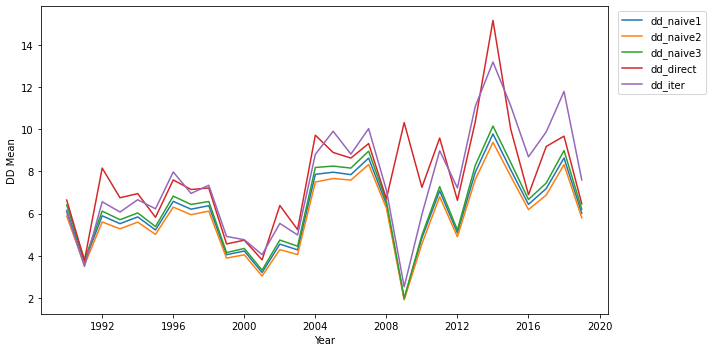

In [23]:
# DD Mean for each Year for Method 1, Method 2, and Method 3

plot_df(df_123_list[0], True, 5, 'DD Mean', None, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

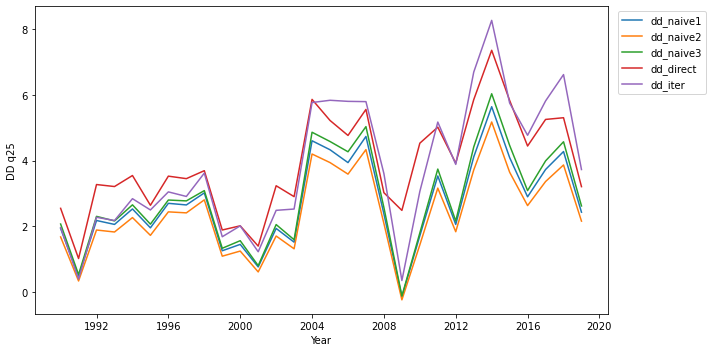

In [24]:
# DD q25 for each Year for Method 1, Method 2, and Method 3

plot_df(df_123_list[1], True, 5, 'DD q25', None, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

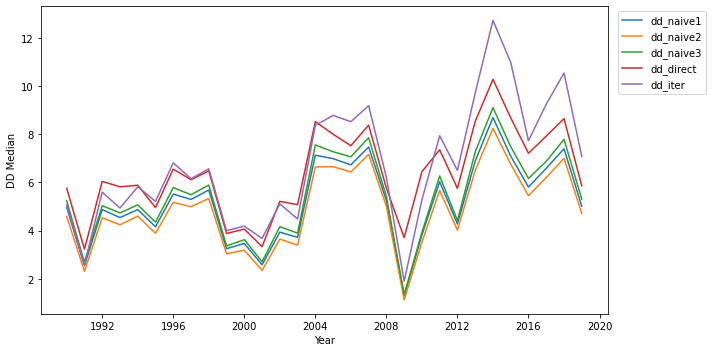

In [25]:
# DD Median for each Year for Method 1, Method 2, and Method 3

plot_df(df_123_list[2], True, 5, 'DD Median', None, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

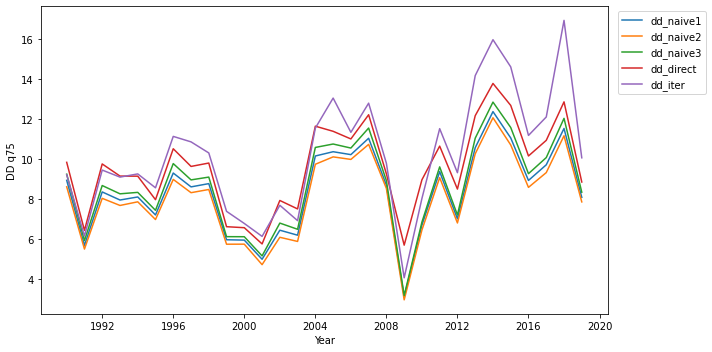

In [26]:
# DD q75 for each Year for Method 1, Method 2, and Method 3

plot_df(df_123_list[3], True, 5, 'DD q75', None, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

The iterative method distance to default calculations are generally similar to the direct solving method values. It does not appear to be more consistently larger or smaller than the direct solving. It is almost always larger than all the naive method distance to default values though. 

In [27]:
# Method 1 DD and PD Descriptive Stats for NBER Recession = 1

kmv1_rec1_dd
kmv1_rec1_pd

,dd_naive1,dd_naive2,dd_naive3
count,24067.000000,24067.000000,24067.000000
mean,4.499108,4.291992,4.694478
std,7.131849,7.092051,7.486124
min,-5.095763,-3.295008,-7.705432
q25,1.241035,1.038200,1.340101
median,3.445964,3.150472,3.669276
q75,6.406428,6.087949,6.735391
max,782.608265,781.009107,843.751720


,pd_naive1,pd_naive2,pd_naive3
count,2.406700e+04,2.406700e+04,2.406700e+04
mean,1.339617e-01,1.421649e-01,1.310588e-01
std,2.603314e-01,2.578472e-01,2.622161e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
q25,7.448708e-11,5.718330e-10,8.174516e-12
median,2.845128e-04,8.150353e-04,1.216190e-04
q75,1.072964e-01,1.495884e-01,9.010632e-02
max,9.999998e-01,9.995079e-01,1.000000e+00


In [28]:
# Method 1 DD and PD Descriptive Stats for NBER Recession = 0

kmv1_rec0_dd
kmv1_rec0_pd

,dd_naive1,dd_naive2,dd_naive3
count,167964.000000,167964.000000,167964.000000
mean,6.066355,5.792643,6.332739
std,5.635027,5.571033,9.308054
min,-9.010434,-9.125004,-9.009234
q25,2.429989,2.140018,2.582968
median,5.052460,4.709231,5.330385
q75,8.395996,8.071891,8.776647
max,303.571116,303.564969,2985.099231


,pd_naive1,pd_naive2,pd_naive3
count,1.679640e+05,1.679640e+05,1.679640e+05
mean,7.054502e-02,7.821557e-02,6.829342e-02
std,1.895091e-01,1.928831e-01,1.898363e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
q25,2.309801e-17,3.460889e-16,8.421053e-19
median,2.180774e-07,1.243264e-06,4.900227e-08
q75,7.549631e-03,1.617665e-02,4.897717e-03
max,1.000000e+00,1.000000e+00,1.000000e+00


In [29]:
# Method 2 DD and PD Descriptive Stats for NBER Recession = 1

kmv2_rec1

,dd_bs,pd_bs
count,21693.000000,2.169300e+04
mean,5.809968,9.240327e-02
std,44.843525,2.383048e-01
min,-409.733278,0.000000e+00
q25,2.153647,2.037441e-14
median,4.502837,3.352611e-06
q75,7.558582,1.563393e-02
max,5998.446174,1.000000e+00


In [30]:
# Method 2 DD and PD Descriptive Stats for NBER Recession = 0

kmv2_rec0

,dd_bs,pd_bs
count,158552.000000,1.585520e+05
mean,7.143182,4.921995e-02
std,30.055834,1.740685e-01
min,-3043.085480,0.000000e+00
q25,3.320130,5.409687e-22
median,6.084459,5.844259e-10
q75,9.568762,4.498775e-04
max,9097.011641,1.000000e+00


In [31]:
# Method 3 DD and PD Descriptive Stats for NBER Recession = 1

kmv3_rec1

,dd_iter,pd_iter
count,724.000000,7.240000e+02
mean,4.497990,1.478861e-01
std,4.807508,2.910812e-01
min,-15.593645,2.376437e-279
q25,1.309890,2.137755e-11
median,3.779055,7.873838e-05
q75,6.594222,9.511664e-02
max,35.694843,1.000000e+00


In [32]:
# Method 3 DD and PD Descriptive Stats for NBER Recession = 0

kmv3_rec0

,dd_iter,pd_iter
count,9131.000000,9.131000e+03
mean,6.930655,7.692658e-02
std,6.342823,2.150293e-01
min,-143.307661,0.000000e+00
q25,2.779045,1.013166e-23
median,6.024261,8.494210e-10
q75,9.971747,2.725950e-03
max,59.382654,1.000000e+00


In [33]:
# get all median pd vals
df_123_median_pd = plot_vals_123.loc[:, [('date', ''), ('pd_naive1', 'median'), ('pd_naive2', 'median'), 
                                       ('pd_naive3', 'median'), ('pd_bs', 'median'), ('pd_iter', 'median')]]

df_123_median_pd.columns = ['date', 'dd_naive1', 'dd_naive2', 'dd_naive3', 'dd_direct', 'dd_iter']

<Figure size 432x288 with 0 Axes>

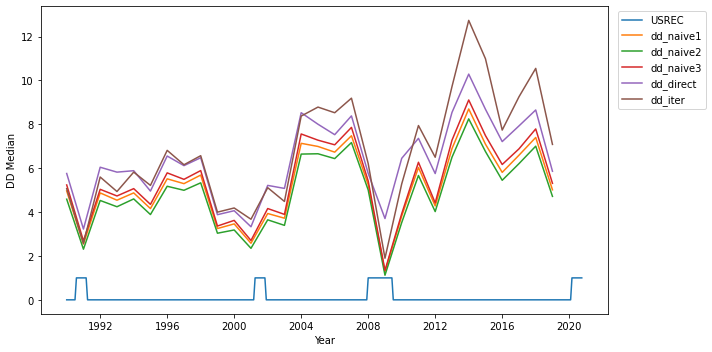

In [34]:
# DD Median values with NBER Recession Data
plot_df(df_123_list[2], True, 5, 'DD Median', usrec_1990, None, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

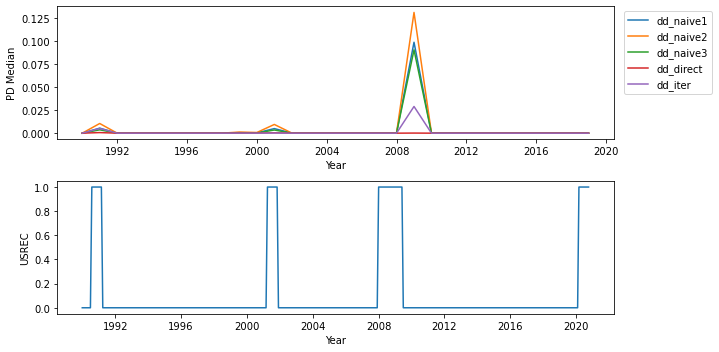

In [35]:
# PD Median values with NBER Recession Data
plot_df(df_123_median_pd, True, 5, 'PD Median', usrec_1990, None, None, sub_plot=True, 
        fig_size=(10, 5), legend_loc='upper left', legend_bbox=(1.01, 1))

For all the distance to default calculation methods, when NBER Recession is 1, the distance to default calculations are smaller and the probability to default values are higher than when the NBER recession is 0. This occurs for the mean, q25, median, and q75.

Additionally in the graphs, we can see the distance to default median decreasing when the recession indicator is 1. The probability to default median also drastically increases during the recession inidicator being 1 in 1990-1991, 2001, and the great recession in 2008.

<Figure size 432x288 with 0 Axes>

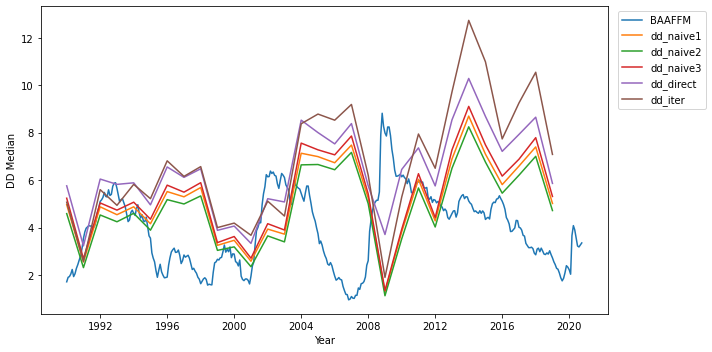

In [36]:
# DD Median values with Moody's BAA-Fed Fund Spread
plot_df(df_123_list[2], True, 5, 'DD Median', None, baaffm_1990, None, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

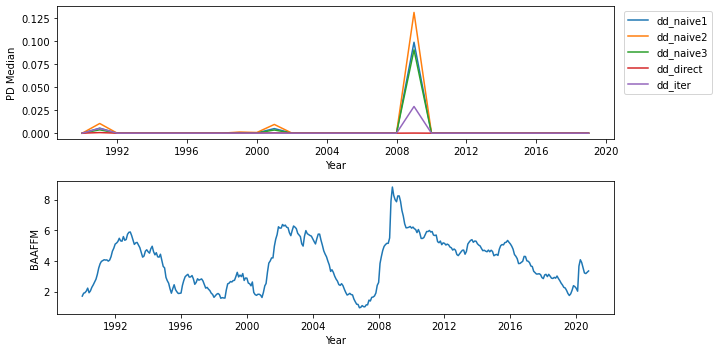

In [37]:
# PD Median values with Moody's BAA-Fed Fund Spread
plot_df(df_123_median_pd, True, 5, 'PD Median', None, baaffm_1990, None, sub_plot=True,
        fig_size=(10, 5), legend_loc='upper left', legend_bbox=(1.01, 1))

The distance to default values seem to occasionallly inversely mirror the Moody's BAA-Fed Fund Spread. We see an increase in the early 1990s and then decrease in BAAFFM, but a decrease in early 1990s and then increase in the distance to default. From 2000 to 2008, the BAAFFM is decreasing, but the distance to default is increasing. After 2008, the BAAFFM sharply increases and the distance to default sharply drops. Then, as BAAFFM decreases until 2020, the distance to default is increasing. Since DD and PD are inversely related, we can additionally see the increase in probability of default in the early 1990s along with the increase in BAAFFM those years. This similarly happens in 2001, and then 2008-2009.

<Figure size 432x288 with 0 Axes>

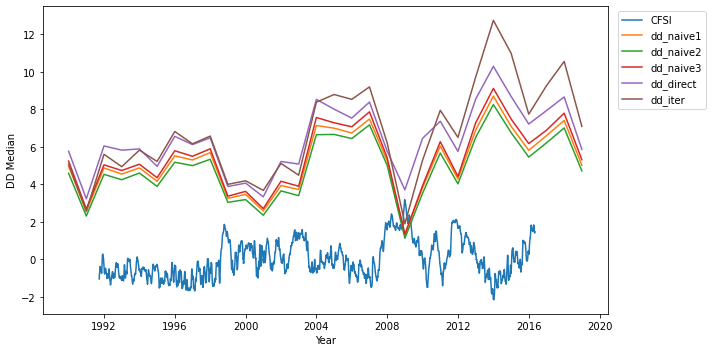

In [38]:
# DD Median values with CFSI
plot_df(df_123_list[2], True, 5, 'DD Median', None, None, cfsi, fig_size=(10, 5), 
        legend_loc='upper left', legend_bbox=(1.01, 1))

<Figure size 432x288 with 0 Axes>

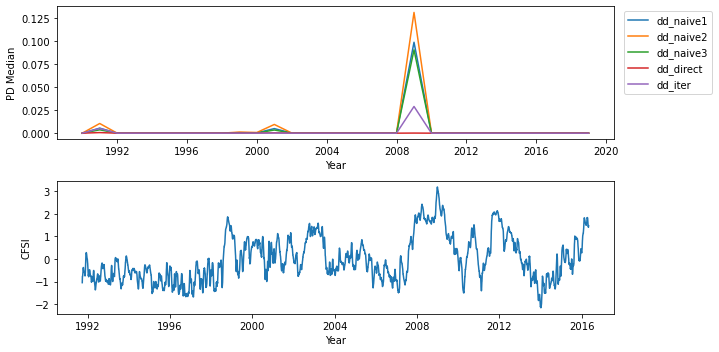

In [39]:
# PD Median values with CFSI
plot_df(df_123_median_pd, True, 5, 'PD Median', None, None, cfsi, sub_plot=True,
        fig_size=(10, 5), legend_loc='upper left', legend_bbox=(1.01, 1))

The Cleveland Financial Stress Index and distance to default calculations appear to be inversely correlated. Periods of high financial stress, like 2009 show a high CFSI and low distance to default. Similarly, we see the high probability of default in 2009, mirrorring the increased CFSI.